In [1]:
import numpy as np
import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

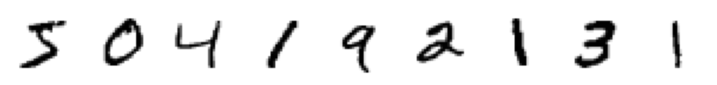

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 9, figsize = (9, 1))
axs = axs.flatten()

for i in range(9):
    plt.sca(axs[i])
    plt.imshow(x_train[i], cmap = 'binary')
    plt.axis('off')
plt.show()

In [3]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [4]:
x_train = x_train / 255
x_test = x_test / 255

In [5]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

In [6]:
import time

import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier(random_state = 42, verbose = -1)

x = time.time()
lgb_clf.fit(x_train, y_train)
print('done', time.time() - x)

done 27.307220697402954


In [7]:
from sklearn.metrics import accuracy_score

pred = lgb_clf.predict(x_test)

acc = accuracy_score(y_test, pred)

print(acc)

0.9774


### 이진 분류

In [8]:
# 이미지가 5를 나타내는지 만을 판단하는 모델을 훈련시켜본다. 

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

lgb_clf_5 = lgb.LGBMClassifier(random_state = 42, verbose = -1)
lgb_clf_5.fit(x_train, y_train_5)

LGBMClassifier(random_state=42, verbose=-1)

In [9]:
# 오차 행렬
from sklearn.metrics import confusion_matrix

y_train_pred = lgb_clf_5.predict(x_train)

confusion_matrix(y_train_5, y_train_pred)

array([[54576,     3],
       [   13,  5408]], dtype=int64)

오차 행렬은 다음 구조를 가지고 있다.

```
TN | FP
---|---
FN | TP
```

*   TN : True Negetive, 실제 거짓 값을 거짓으로 예측, 여기서는 5가 아닌 것을 5가 아니라고 예측
*   FP : False Positive, 실제 거짓 값을 참으로 예측, 여기서는 5가 아닌 것을 5라고 예측
*   FN : False Negetive, 실제 참 값을 거짓으로 예측, 여기서는 5인 것을 5가 아니라고 예측
*   TP : True Positive, 실제 참 값을 참으로 예측, 여기서는 5인 것을 5라고 예측



In [10]:
# 정확도, 전체 데이터 중 맞춘 비율
# (TN + TP) / (TN + FP + FN + TP)

accuracy_score(y_train_5, y_train_pred)

0.9997333333333334

In [11]:
# 정밀도와 재현율
# 정밀도 : 참이라고 한 예측이 올바른 정도 TP / (FP + TP)
# 재현율 : 실제 참인 데이터를 참이라고 예측한 정도 TP / (FN + TP)
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.9994455738310848
0.9976019184652278


정밀도(precision)와 재현율(recall)은 한 쪽이 증가하면 한 쪽은 감소하는 **트레이드 오프** 관계이다.

In [13]:
from sklearn.model_selection import cross_val_predict

y_proba = cross_val_predict(lgb_clf_5, x_train, y_train_5, cv=3,
                                    method="predict_proba")

y_proba = y_proba[:, 1]

In [14]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_proba)

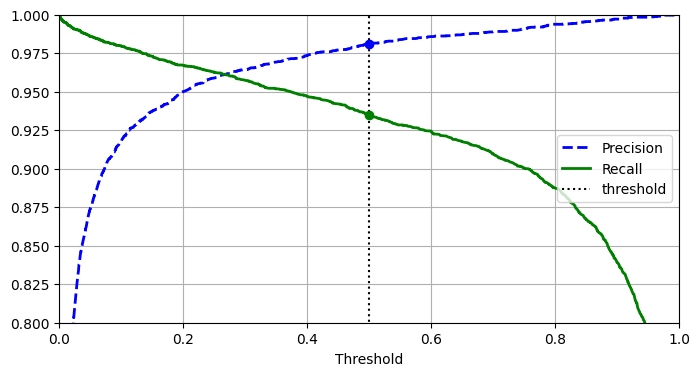

In [15]:
plt.figure(figsize=(8, 4))

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

threshold = 0.5
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")

plt.axis([0, 1, 0.8, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

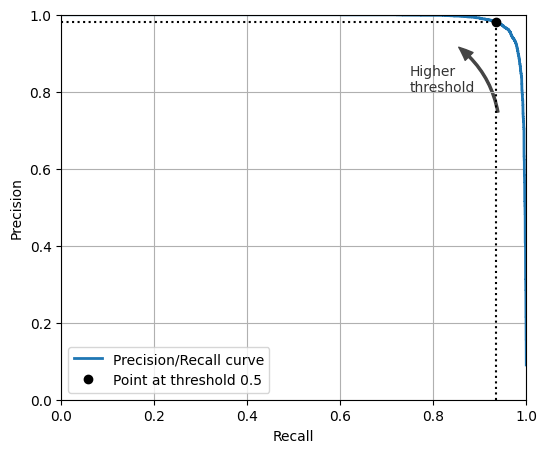

In [16]:
import matplotlib.patches as patches

plt.figure(figsize=(6, 5))

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 0.5")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.94, 0.74), (0.85, 0.92),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))

plt.text(0.75, 0.8, "Higher\nthreshold", color="#333333")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

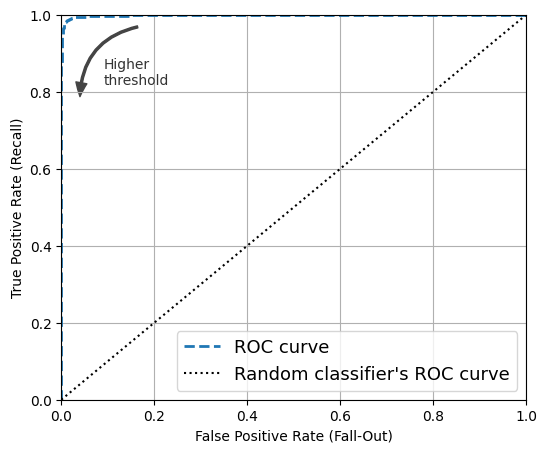

In [17]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_proba)

plt.figure(figsize=(6, 5))

plt.plot(fpr, tpr, '--', linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.17, 0.97), (0.04, 0.78),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.09, 0.82, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

In [18]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_proba)

0.9985376146102047

### 다중 클래스 분류

In [19]:
print(confusion_matrix(y_test, pred))

[[ 969    0    0    0    0    3    3    1    4    0]
 [   0 1127    1    2    0    1    1    0    3    0]
 [   3    0 1008    5    2    0    1    5    8    0]
 [   0    0    4  989    0    3    0    9    5    0]
 [   0    0    5    1  959    0    3    0    2   12]
 [   2    2    1    8    0  863    7    3    4    2]
 [   6    2    0    0    3    6  937    0    4    0]
 [   1    2   15    3    2    0    0  996    2    7]
 [   4    1    2    2    3    2    2    2  951    5]
 [   4    5    1    8    7    1    0    4    4  975]]


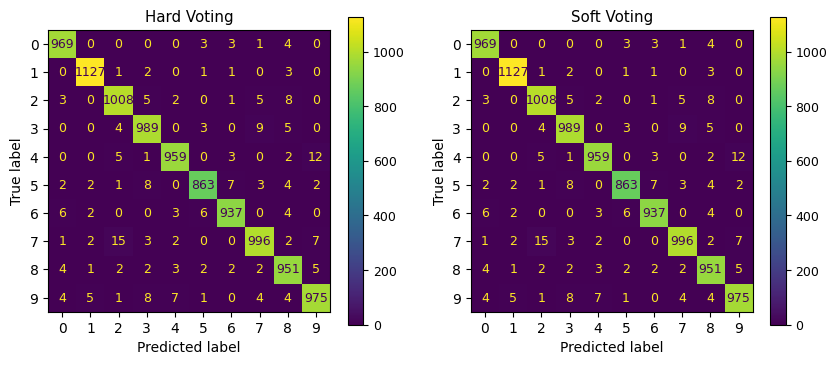

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 2, figsize = (10, 4))
axs = axs.flatten()

plt.rc('font', size=9)

ConfusionMatrixDisplay.from_predictions(y_test, pred, ax = axs[0])
axs[0].set_title('Hard Voting')

# ConfusionMatrixDisplay.from_predictions(y_test, vot_pred1, ax = axs[1], normalize = 'true', values_format = '.0%')
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax = axs[1])
axs[1].set_title('Soft Voting')

plt.show()

### 데이터 증식

In [21]:
from scipy.ndimage import shift

def image_shift(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, (dy, dx))
    return shifted_image

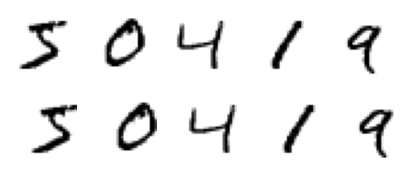

In [23]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

fig, axs = plt.subplots(2, 5, figsize = (5, 2))
axs = axs.flatten()

for i in range(5):
    img = image_shift(x_train[i], 5, 0)
    plt.sca(axs[i])
    plt.imshow(x_train[i], cmap = 'binary')
    plt.axis('off')

    plt.sca(axs[i + 5])
    plt.imshow(img, cmap = 'binary')
    plt.axis('off')

plt.show()

In [24]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train_augmented = [i for i in x_train]
y_train_augmented = [i for i in y_train]

for dx, dy in ((-2, 0), (2, 0), (0, 2), (0, -2)):
    for image, label in zip(x_train, y_train):
        x_train_augmented.append(image_shift(image, dx, dy))
        y_train_augmented.append(label)

x_train_augmented = np.array(x_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [25]:
x_train_augmented = x_train_augmented / 255
x_test = x_test / 255

x_train_augmented = x_train_augmented.reshape(x_train_augmented.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

In [26]:
lgb_clf = lgb.LGBMClassifier(random_state = 42, verbose = -1)

lgb_clf.fit(x_train_augmented, y_train_augmented)

pred = lgb_clf.predict(x_test)

print(accuracy_score(y_test, pred)) # 0.9774

0.9766


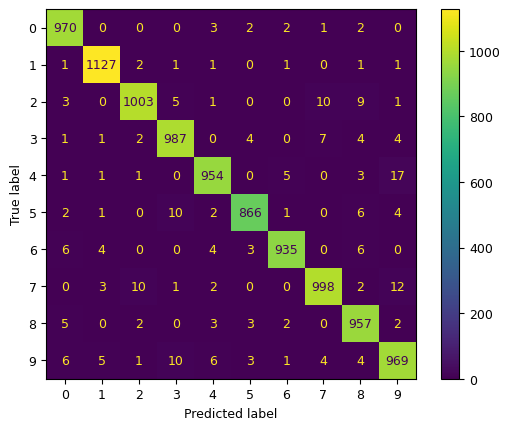

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, pred)

plt.show()

In [ ]:
# 이미지 증강을 사용하였을 때 정확도가 약간 감소하였다. LightGBM 대신 SVC를 사용하면 더 성능이 좋다.
'''
[[ 969    0    0    0    0    3    3    1    4    0]
 [   0 1127    1    2    0    1    1    0    3    0]
 [   3    0 1008    5    2    0    1    5    8    0]
 [   0    0    4  989    0    3    0    9    5    0]
 [   0    0    5    1  959    0    3    0    2   12]
 [   2    2    1    8    0  863    7    3    4    2]
 [   6    2    0    0    3    6  937    0    4    0]
 [   1    2   15    3    2    0    0  996    2    7]
 [   4    1    2    2    3    2    2    2  951    5]
 [   4    5    1    8    7    1    0    4    4  975]]
 '''